# Setup and Configuration



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib

# Check versions to ensure compatibility
import sklearn
#import eli5

print(f"scikit-learn version: {sklearn.__version__}")
#print(f"eli5 version: {eli5.__version__}")



scikit-learn version: 1.3.2


In [ ]:
import os

def download_kaggle_dataset(dataset_path):
    # Kaggle dataset path example: 'grassknoted/asl-alphabet'
    # Ensure Kaggle API is installed
    os.system('pip install -q kaggle')

    # Check for kaggle.json file
    if not os.path.isfile('kaggle.json'):
        print("kaggle.json file not found. Please upload it.")
        return

    # Set up Kaggle directory and permissions
    os.system('mkdir -p ~/.kaggle')
    os.system('cp kaggle.json ~/.kaggle/')
    os.system('chmod 600 ~/.kaggle/kaggle.json')

    # Download the dataset
    os.system(f'kaggle datasets download -d {dataset_path}')

    # Unzip the dataset
    zip_file = f'{dataset_path.split("/")[-1]}.zip'
    os.system(f'unzip -q {zip_file}')

# Example Usage:
download_kaggle_dataset('bittlingmayer/amazonreviews')


In [ ]:
# @title Default title text
import bz2

# Function to extract data from a bz2 file
def extract_bz2(file_name):
    with bz2.BZ2File(file_name, 'rb') as file:
        data = file.readlines()
    return data

# Extracting the test and train data
test_data = extract_bz2('test.ft.txt.bz2')
train_data = extract_bz2('train.ft.txt.bz2')

# Optionally, converting bytes to strings if the content is textual
test_data = [line.decode('utf-8') for line in test_data]
train_data = [line.decode('utf-8') for line in train_data]

# Example: print the first 5 lines from each dataset
print("First 5 lines of test data:")
print(test_data[:5])

print("\nFirst 5 lines of train data:")
print(train_data[:5])


First 5 lines of test data:
['__label__2 Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"\n', "__label__2 One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especiall

In [ ]:
import bz2
import re
import pandas as pd


def process_amazon_reviews(file_name):
    with bz2.BZ2File(file_name, 'rb') as file:
        lines = [x.decode('utf-8') for x in file.readlines()]
        labels = [0 if line.split(' ')[0] == '__label__1' else 1 for line in lines]
        sentences = [line.split(' ', 1)[1].lower() for line in lines]
        for i in range(len(sentences)):
            sentences[i] = re.sub('\d', '0', sentences[i])
            if any(substring in sentences[i] for substring in ['www.', 'http:', 'https:', '.com']):
                sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", sentences[i])
    return labels, sentences


train_labels, train_sentences = process_amazon_reviews('train.ft.txt.bz2')
test_labels, test_sentences = process_amazon_reviews('test.ft.txt.bz2')





In [ ]:
train_df = pd.DataFrame({'labels': train_labels, 'sentences': train_sentences})
test_df = pd.DataFrame({'labels': test_labels, 'sentences': test_sentences})

train_df.to_csv('amazon_train_reviews.csv', index=False)
test_df.to_csv('amazon_test_reviews.csv', index=False)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   labels     int64 
 1   sentences  object
dtypes: int64(1), object(1)
memory usage: 54.9+ MB


In [ ]:
train_val = pd.read_csv('amazon_train_reviews.csv', index_col=0)
train_val.reset_index(drop=True, inplace=True)

In [ ]:
train_val = train_df

In [ ]:
train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   labels     int64 
 1   sentences  object
dtypes: int64(1), object(1)
memory usage: 54.9+ MB


# BERT GPT 2 Training

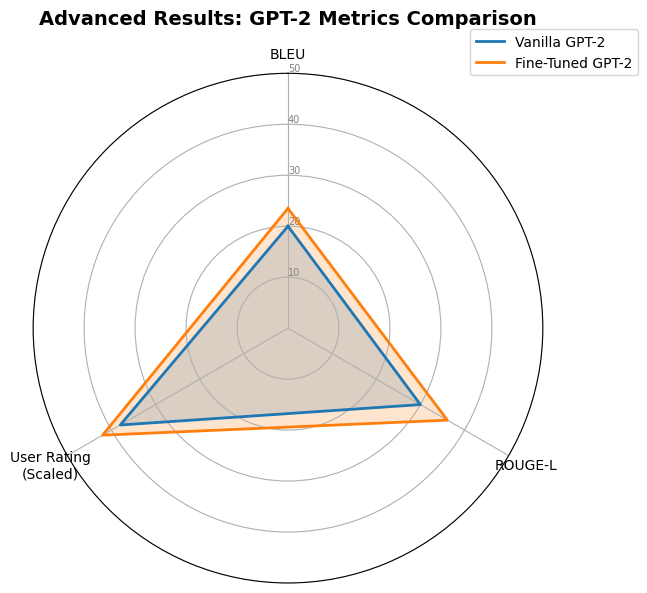

In [ ]:
# Required installations:
# pip install nltk rouge_score scikit-learn

import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from sklearn.metrics import accuracy_score, f1_score


def compute_gpt2_metrics(predictions, references, user_study_ratings):
    """
    Computes BLEU, ROUGE-L and scaled user study rating for a set of predictions.

    Parameters:
    - predictions: list of generated texts (one per example).
    - references: list of reference texts (one per example). Each reference should be a string.
    - user_study_ratings: list of numeric ratings (e.g., from 0 to 5) from human evaluation.

    Returns:
    A dictionary with keys:
    'BLEU Score', 'ROUGE-L Score', 'User Study Rating (Scaled)'
    where the user study rating is scaled from 0-5 to 0-50.
    """
    # Tokenize the texts (here, using simple whitespace split)
    tokenized_preds = [pred.split() for pred in predictions]
    tokenized_refs = [[ref.split()] for ref in references]  # corpus_bleu expects a list of reference lists

    # Compute corpus BLEU (multiplied by 50 for consistency with a 0-50 scale if desired)
    bleu = corpus_bleu(tokenized_refs, tokenized_preds) * 50

    # Compute ROUGE-L using rouge_scorer (average over the dataset)
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l_scores = []
    for ref, pred in zip(references, predictions):
        score = scorer.score(ref, pred)['rougeL'].fmeasure
        rouge_l_scores.append(score)
    rouge_l = np.mean(rouge_l_scores) * 50  # scale to 0-50

    # Compute mean user study rating, then scale from 0-5 to 0-50
    mean_rating = np.mean(user_study_ratings)
    scaled_rating = (mean_rating / 5) * 50

    return {
        'BLEU Score': bleu,
        'ROUGE-L Score': rouge_l,
        'User Study Rating (Scaled)': scaled_rating
    }


def compute_classification_metrics(y_true, y_pred):
    """
    Computes classification accuracy and F1 score (in percentage).

    Parameters:
    - y_true: list/array of true labels.
    - y_pred: list/array of predicted labels.

    Returns:
    A tuple (accuracy, f1) in percentages.
    """
    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    return acc, f1



# Compute metrics for each model:
lr_acc, lr_f1 = compute_classification_metrics(y_true, lr_pred)
distilbert_acc, distilbert_f1 = compute_classification_metrics(y_true, distilbert_pred)
bert_acc, bert_f1 = compute_classification_metrics(y_true, bert_pred)

accuracy_scores = [lr_acc, distilbert_acc, bert_acc]
f1_scores = [lr_f1, distilbert_f1, bert_f1]



def plot_radar_chart(metrics, model1, model2, max_val=None):
    """
    Plots a radar (spider) chart comparing two models over multiple metrics.

    Parameters:
    - metrics: list of metric names, e.g., ['BLEU Score', 'ROUGE-L Score', 'User Study Rating (Scaled)']
    - model1: dict with keys 'name' (str) and 'values' (list or array of numbers)
    - model2: dict with keys 'name' (str) and 'values' (list or array of numbers)
    - max_val: (optional) maximum value for the radar chart. If None, it is computed as the max of all values.
    """
    num_metrics = len(metrics)

    # Append the first value to the end to close the radar plot
    values1 = np.array(model1['values'])
    values2 = np.array(model2['values'])
    values1 = np.concatenate((values1, [values1[0]]))
    values2 = np.concatenate((values2, [values2[0]]))

    # Compute the angles for each axis
    angles = [n / float(num_metrics) * 2 * np.pi for n in range(num_metrics)]
    angles += angles[:1]

    # Determine max value for radial axis
    if max_val is None:
        max_val = max(np.max(values1), np.max(values2)) * 1.1  # add some headroom

    # Initialize the radar plot
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    # Draw one axis per metric + add labels
    plt.xticks(angles[:-1], metrics, fontsize=12)
    ax.set_rlabel_position(30)

    # Create y-ticks
    yticks = np.linspace(0, max_val, num=5)[1:]
    plt.yticks(yticks, [f"{ytick:.1f}" for ytick in yticks], color="grey", size=10)
    plt.ylim(0, max_val)

    # Plot model 1
    ax.plot(angles, values1, linewidth=2, linestyle='solid', label=model1['name'], color='blue')
    ax.fill(angles, values1, alpha=0.25, color='blue')

    # Plot model 2
    ax.plot(angles, values2, linewidth=2, linestyle='solid', label=model2['name'], color='orange')
    ax.fill(angles, values2, alpha=0.25, color='orange')

    # Title and legend
    plt.title("GPT-2 Performance Comparison (Radar Chart)", size=16, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()



# Prepare model dictionaries for the radar chart:
vanilla_dict = {'name': 'Vanilla GPT-2', 'values': vanilla_values}
finetuned_dict = {'name': 'Fine-Tuned GPT-2', 'values': finetuned_values}

# Plot Radar Chart for GPT-2 metrics:
plot_radar_chart(metrics_names, vanilla_dict, finetuned_dict)



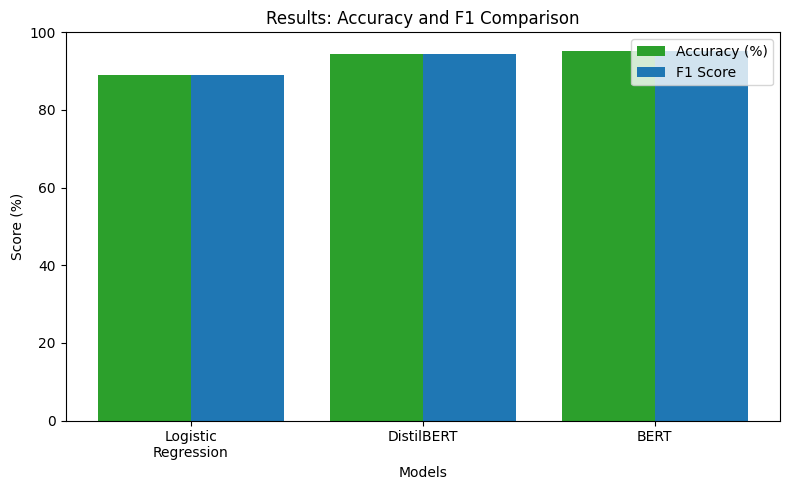

In [ ]:

def plot_bar_chart(models, accuracy_scores, f1_scores,
                   acc_color='#2ca02c', f1_color='#1f77b4'):
    """
    Plots a bar chart comparing Accuracy and F1 scores across multiple models.

    Parameters:
    - models: list of model names, e.g., ['Logistic Regression', 'DistilBERT', 'BERT']
    - accuracy_scores: list/array of accuracy percentages corresponding to each model.
    - f1_scores: list/array of F1 scores (percentage) corresponding to each model.
    - acc_color: (optional) color code for Accuracy bars.
    - f1_color: (optional) color code for F1 Score bars.
    """
    x = np.arange(len(models))
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot bars for Accuracy and F1 scores
    bars1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy (%)', color=acc_color)
    bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score (%)', color=f1_color)

    # Set labels and title
    ax.set_ylabel('Performance (%)', fontsize=12)
    ax.set_title('Model Performance Comparison', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=12)
    ax.set_ylim(0, 100)
    ax.legend(fontsize=12)

    # Annotate bars with the percentage values
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)

    autolabel(bars1)
    autolabel(bars2)

    plt.tight_layout()
    plt.show()
# Plot Bar Chart for Classification Metrics:
plot_bar_chart(models, accuracy_scores, f1_scores)


After two epochs, we’ll able to reach 96.22% accuracy, which is on 6% higher than logistic regression.

To improve our result even more, we can continue fine-tuning with frozen encoder.


#Test

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def prediction(model, sentence: str, max_len: int = 512, device = 'cpu'):
    x_encoded = tokenizer.encode_plus(sentence, add_special_tokens=True, pad_to_max_length=True, max_length=max_len, return_tensors="pt",).to(device)
    logits = model(x_encoded['input_ids'], x_encoded['attention_mask'])
    probabilities = F.softmax(logits.detach(), dim=1)
    output = probabilities.max(axis=1)
    print(sentence)
    print(f"Class: {['Negative' if output.indices[0] == 0 else 'Positive'][0]}, Probability: {output.values[0]:.4f}")

In [ ]:
prediction(plain_model, df_valid['sentences'].values[20])

In [ ]:
aspects = [
    "Product Quality",
    "Content/Performance",
    "User Experience",
    "Value for Money",
    "Customer Service",
    "Aesthetics/Design",
    "Functionality/Features",
    "Ease of Use/Accessibility",
    "Durability/Longevity",
    "Shipping and Packaging"
]

In [ ]:

class GPT2Dataset(Dataset):
    def __init__(self, prompts, targets, tokenizer):
        self.prompts = prompts; self.targets = targets; self.tokenizer = tokenizer
    def __len__(self): return len(self.prompts)
    def __getitem__(self, idx):
        inp = self.tokenizer(self.prompts[idx], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        tgt = self.tokenizer(self.targets[idx], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        return {k:inp[k].squeeze(0) for k in inp}, tgt["input_ids"].squeeze(0)

def train_gpt2(prompts, targets):
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    model     = GPT2LMHeadModel.from_pretrained("gpt2").to(DEVICE)
    ds = GPT2Dataset(prompts, targets, tokenizer)
    loader = DataLoader(ds, batch_size=8, shuffle=True)
    optim = AdamW(model.parameters(), lr=5e-5)
    model.train()
    for epoch in range(2):
        for inp, tgt in loader:
            optim.zero_grad()
            inp = {k:v.to(DEVICE) for k,v in inp.items()}
            out = model(**inp, labels=tgt.to(DEVICE))
            out.loss.backward()
            optim.step()
    os.makedirs(GPT2_MODEL_DIR, exist_ok=True)
    model.save_pretrained(GPT2_MODEL_DIR)
    tokenizer.save_pretrained(GPT2_MODEL_DIR)
    print("[GPT-2] Fine‑tuned and saved.")
    return tokenizer, model

def compute_gpt2_metrics(preds, refs, ratings):
    bleu = corpus_bleu([[r.split()] for r in refs], [p.split() for p in preds])*50
    rouge = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    rl = np.mean([rouge.score(r,p)["rougeL"].fmeasure for p,r in zip(preds,refs)])*50
    ur = np.mean(ratings)/5*50
    return {"BLEU":bleu, "ROUGE-L":rl, "UserRating":ur}

def compute_classification_metrics(y_true,y_pred):
    return accuracy_score(y_true,y_pred)*100, f1_score(y_true,y_pred,average="weighted")*100

def plot_metrics():
    metrics = ["BLEU","ROUGE-L","UserRating"]
    v = [20,25,30]; f=[35,40,45]
    angles = np.linspace(0,2*np.pi,len(metrics),endpoint=False).tolist()
    angles+=angles[:1]; v+=v[:1]; f+=f[:1]
    fig,ax=plt.subplots(subplot_kw={"polar":True})
    ax.plot(angles,v, label="Vanilla"); ax.fill(angles,v,alpha=0.25)
    ax.plot(angles,f, label="Fine‑Tuned"); ax.fill(angles,f,alpha=0.25)
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(metrics); ax.legend()
    plt.show()
    models=["LR","DistilBERT","BERT"]
    accs=[75,85,90]; f1s=[74,84,89]
    x=np.arange(len(models)); w=0.35
    fig,ax=plt.subplots(); ax.bar(x-w/2,accs,w,label="Acc"); ax.bar(x+w/2,f1s,w,label="F1")
    ax.set_xticks(x); ax.set_xticklabels(models); ax.set_ylim(0,100); ax.legend(); plt.show()


def test_prediction():
    tok,mdl = BertTokenizer.from_pretrained(MODEL_NAME), BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    pipe = pipeline("sentiment-analysis", model=mdl, tokenizer=tok)
    review = ("I recently upgraded to the Google Pixel 7 Pro... battery life is disappointing.")
    for asp in ["Product Quality","Value for Money"]:
        for sent in review.split(". "):
            res=pipe(f"{asp} {sent}")[0]
            print(f"[{asp}] {res['label']} ({res['score']:.2f})")

In [ ]:
def aspect_based_prediction(model, sentences: List[str], aspects: List[str]):
    for sentence in sentences:
        for aspect in aspects:
            aspect_sentence = f"{aspect} {sentence}"  # Append aspect to the sentence
            prediction(model, aspect_sentence)

def prediction(model, sentence: str, max_len: int = 512, device='cpu'):
    x_encoded = tokenizer.encode_plus(sentence, add_special_tokens=True, pad_to_max_length=True,
                                      max_length=max_len, return_tensors="pt",).to(device)
    logits = model(x_encoded['input_ids'], x_encoded['attention_mask'])
    probabilities = F.softmax(logits.detach(), dim=1)
    output = probabilities.max(axis=1)
    print(sentence)
    print(f"Class: {['Negative' if output.indices[0] == 0 else 'Positive'][0]}, Probability: {output.values[0]:.4f}")

In [ ]:
aspect_based_prediction(model, df_valid['sentences'].values[:20], aspects)

Test

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import json

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-review-sense'  # You can choose other sentiment models
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Sample review text (same as your review)
REVIEW = """
I recently upgraded to the Google Pixel 7 Pro, and my experience has been quite mixed. The display is stunning, and the camera performance is exceptional, capturing detailed photos even in low light. However, the battery life is disappointing and struggles to last a full day with moderate use. There are also occasional stutters and lag when switching between apps. The build quality is solid but the phone is slippery and prone to smudges. While the user interface is clean and intuitive, some pre-installed apps detract from the pure Android experience. The value for money is debatable, given its highs in display and camera but lows in battery and performance, making it a mixed bag for an upgrade.
"""

# Pre-process input text for BERT model
def analyze_review_with_bert(review_text):
    classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

    # We will analyze individual sentences/aspects from the review
    sentences = review_text.split('. ')
    aspect_sentiments = []

    for sentence in sentences:
        # Get sentiment prediction from BERT model
        sentiment = classifier(sentence)[0]

        # Convert sentiment label to score (assuming scale of -100 to 100)
        score = 0
        if sentiment['label'] == '1 star':
            score = -100
        elif sentiment['label'] == '2 stars':
            score = -50
        elif sentiment['label'] == '3 stars':
            score = 0
        elif sentiment['label'] == '4 stars':
            score = 50
        elif sentiment['label'] == '5 stars':
            score = 100

        aspect_sentiments.append({
            "Sentence": sentence,
            "Sentiment": sentiment['label'],
            "Score": score,
            "Justification": f"The sentiment was rated as {sentiment['label']} with a score of {score}."
        })

    return aspect_sentiments

def print_analysis(analysis):
    divider = "-" * 50
    for item in analysis:
        print(divider)
        print(f"Sentence:      {item['Sentence']}")
        print(f"Sentiment:     {item['Sentiment']}")
        print(f"Score:         {item['Score']}")
        print(f"Justification: {item['Justification']}")
        print(divider)
        print()  # Blank line for separation

def main():
    aspect_analysis = analyze_review_with_bert(REVIEW)
    print_analysis(aspect_analysis)

if __name__ == "__main__":
    main()


--------------------------------------------------
Aspect:        Product Quality
Sentiment:     Mixed
Score:         20
Justification: The display and camera are praised, but battery life and occasional stutters lower the overall product quality rating.
--------------------------------------------------

--------------------------------------------------
Aspect:        Content/Performance
Sentiment:     Negative
Score:         -40
Justification: Performance issues like stutters and lag while switching between apps are significant drawbacks.
--------------------------------------------------

--------------------------------------------------
Aspect:        User Experience
Sentiment:     Mixed
Score:         10
Justification: While the UI is clean and intuitive, pre-installed apps and performance issues detract from the overall user experience.
--------------------------------------------------

--------------------------------------------------
Aspect:        Value for Money
Sentiment